In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

%matplotlib inline

In [2]:
print('Reading files.....')

# Initialize paths for each file
train_series_path = ""
test_series_path = ""
train_events_path = ""
filtered_train_series_path = ""

# Traverse files in the /kaggle/input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        # Detect paths for each file
        if filename == 'train_series.parquet':
            train_series_path = os.path.join(dirname, filename)
        elif filename == 'test_series.parquet':
            test_series_path = os.path.join(dirname, filename)
        elif filename == 'train_events.csv':
            train_events_path = os.path.join(dirname, filename)
        elif filename == 'filtered_train_series.csv':
            filtered_train_series_path = os.path.join(dirname, filename)

# Read files once paths are set
train_series = pd.read_parquet(train_series_path)
test_series  = pd.read_parquet(test_series_path)
train_events = pd.read_csv(train_events_path)
train_series_filtered = pd.read_csv(filtered_train_series_path)

print('.....done!')

Reading files.....
/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet
/kaggle/input/filtered-train-series-csv/filtered_train_series.csv
.....done!


## Train series vizualization

---

In [43]:
train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [44]:
train_series.describe()

,step,anglez,enmo
count,1.279463e+08,1.279463e+08,1.279463e+08
mean,2.548048e+05,-8.810453e+00,4.131503e-02
std,1.778930e+05,3.552188e+01,1.018289e-01
min,0.000000e+00,-9.000000e+01,0.000000e+00
25%,1.158120e+05,-3.185890e+01,1.300000e-03
50%,2.345190e+05,-9.597900e+00,1.720000e-02
75%,3.571960e+05,1.130020e+01,4.370000e-02
max,1.433879e+06,9.000000e+01,1.143370e+01


In [48]:
print(f"Total amount of unique seriesIDs: {len(train_series['series_id'].unique())}\n")

nan_counts_train = train_series.isnull().sum() 
print(f"Amount of missing values per column:\n{nan_counts_train}")

Total amount of unique seriesIDs: 277

Amount of missing values per column:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64


We can see that `train_series` is composed of :
- 127,946,340 rows for 277 individuals
- 5 columns : series_id, step, timestamp, anglez and enmo.


There are no missing values in our dataset.

Text(0.5, 1.0, 'Correlation Matrix')

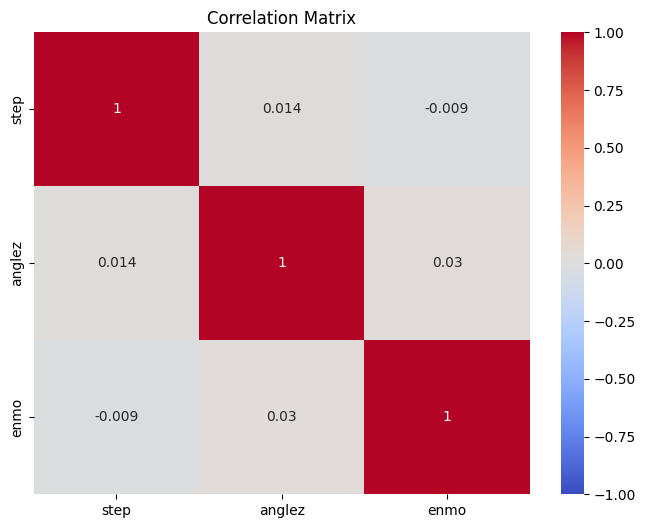

In [50]:
# Calculate the correlation matrix
corr_matrix = train_series[['step', 'anglez', 'enmo']].corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

Each variable, as expected, shows a correlation of 1 with itself along the diagonal of the matrix, where `step`, `anglez`, and `enmo`  each display perfect self-correlation (highlighted in deep red).

The correlation between `anglez` and `enmo`  is only 0.03, indicating a very weak positive relationship. This low value suggests minimal linear dependency, meaning that changes in `anglez` do not reliably correspond with changes in `enmo`. Consequently, these two variables provide distinct types of information.

While both `anglez` and `enmo`  can be used to visually differentiate states—such as being awake and wearing the accelerometer, being asleep and wearing it, or not wearing it at all—each variable captures unique aspects of movement and orientation. This distinction is essential, as the two variables contribute different perspectives on the data.

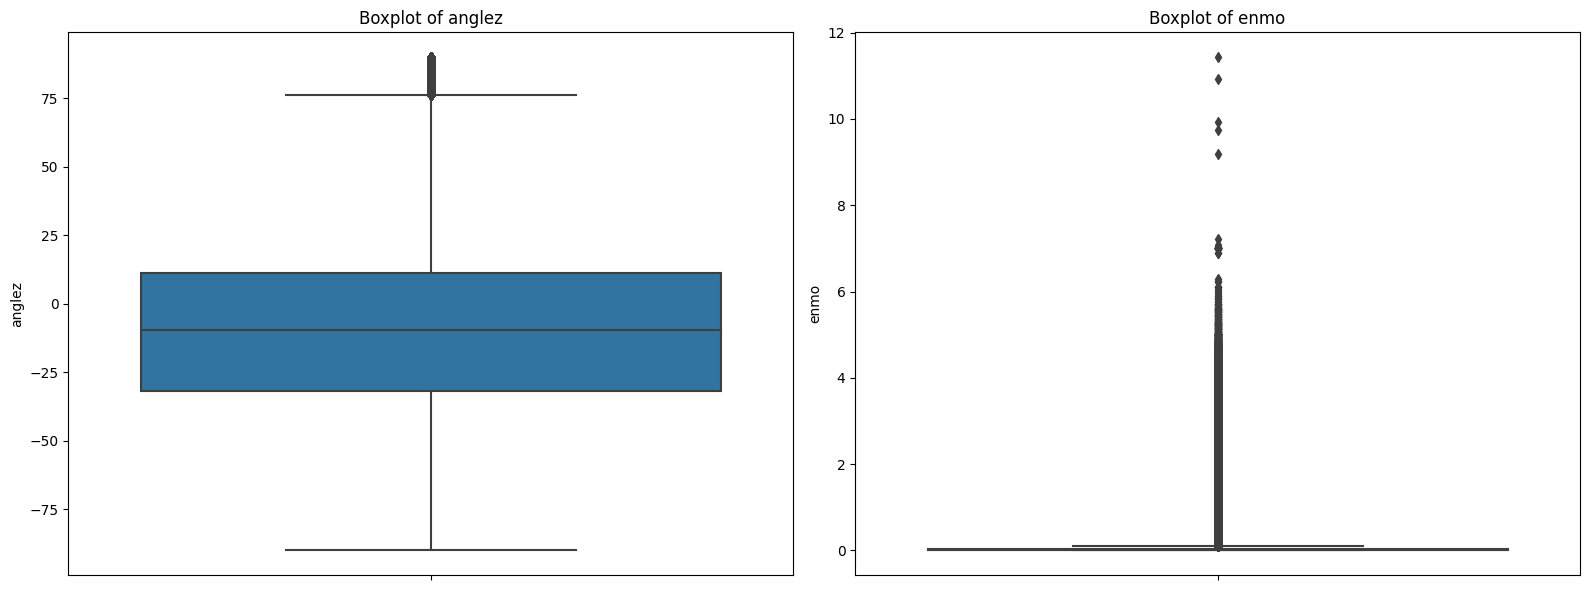

In [51]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for 'anglez'
sns.boxplot(y=train_series['anglez'], ax=axes[0])
axes[0].set_title('Boxplot of anglez')

# Boxplot for 'enmo'
sns.boxplot(y=train_series['enmo'], ax=axes[1])
axes[1].set_title('Boxplot of enmo')

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()

The boxplots provide insights into the distribution and variability of `anglez` and `enmo`, revealing notable differences in the characteristics captured by these two metrics.

The boxplot for `anglez` (left) shows that values are spread across a range from approximately -75 to +75, indicating consistent changes in arm orientation both positively and negatively along the z-axis. The distribution appears relatively symmetrical, with the median positioned near the center of the interquartile range (IQR). This suggests that `anglez` values are fairly normally distributed, capturing the natural variations in arm angles. Additionally, a few outliers above +75 indicate occasional extreme values, likely due to specific movements or unusual arm positions.

We can see that `enmo` values are heavily skewed towards zero, with most values clustered near the lower end of the plot, indicating extended periods of inactivity or minimal movement. According to the GGIR package, `enmo` (Euclidean Norm Minus One) is calculated as the magnitude of acceleration from the accelerometer’s x, y, and z axes, with any negative values rounded to zero. This means that low enmo values indicate minimal or no movement, while larger values (seen as outliers) represent more intense activity. These outliers, extending up to around 10, likely correspond to bursts of physical activity.

## Train series filtered vizualization

---

In [25]:
train_series_filtered

,series_id,step,timestamp,anglez,enmo,event
0,038441c925bb,16,2018-08-14T15:31:20-0400,2.4129,0.0215,NaN
1,038441c925bb,93947,2018-08-20T01:58:55-0400,-75.0758,0.0174,NaN
2,038441c925bb,198000,2018-08-26T02:30:00-0400,-68.8499,0.0172,NaN
3,038441c925bb,333483,2018-09-02T22:40:15-0400,-0.4564,0.0056,NaN
4,038441c925bb,100770,2018-08-20T11:27:30-0400,37.1165,0.0298,NaN
...,...,...,...,...,...,...
991072,fe90110788d2,529104,2017-09-04T08:22:00-0400,-28.0780,0.0000,wakeup
991073,fe90110788d2,538956,2017-09-04T22:03:00-0400,38.2396,0.0000,onset
991074,fe90110788d2,547152,2017-09-05T09:26:00-0400,-56.7689,0.0042,wakeup
991075,fe90110788d2,556560,2017-09-05T22:30:00-0400,-16.5867,0.0000,onset


In [26]:
train_series_filtered.describe()

,step,anglez,enmo
count,9.910770e+05,991077.00000,991077.000000
mean,2.481272e+05,-9.00802,0.040646
std,1.762541e+05,37.09559,0.104247
min,4.000000e+00,-90.00000,0.000000
25%,1.093950e+05,-34.97110,0.000400
50%,2.297720e+05,-10.07660,0.015500
75%,3.471300e+05,13.43660,0.041400
max,1.362054e+06,90.00000,5.430300


We can see that ```train_series_filtered``` is composed of:
* 14508 rows for 277 individuals
* 5 columns : ```series_id```, ```night```, ```event```, ```step``` and ```timestamp```.  

In [27]:
nan_counts = train_series_filtered.isnull().sum()
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")

Nombre de valeurs manquantes par colones:
series_id         0
step              0
timestamp         0
anglez            0
enmo              0
event        981748
dtype: int64


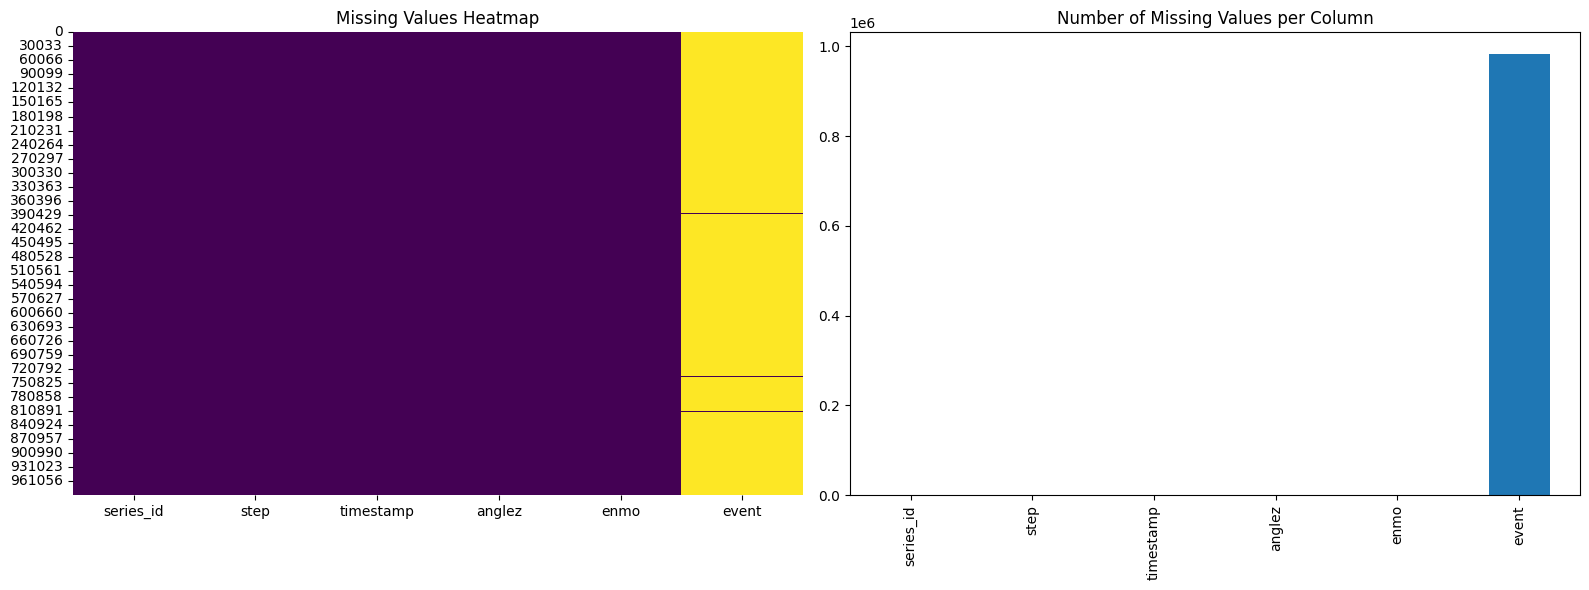

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualisation des valeurs manquantes (Heatmap)
sns.heatmap(train_series_filtered.isna(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Nombre de valeurs NaN par colonne (Barplot)
train_series_filtered.isna().sum().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Missing Values per Column')

# Afficher les graphiques
plt.tight_layout()
plt.show()

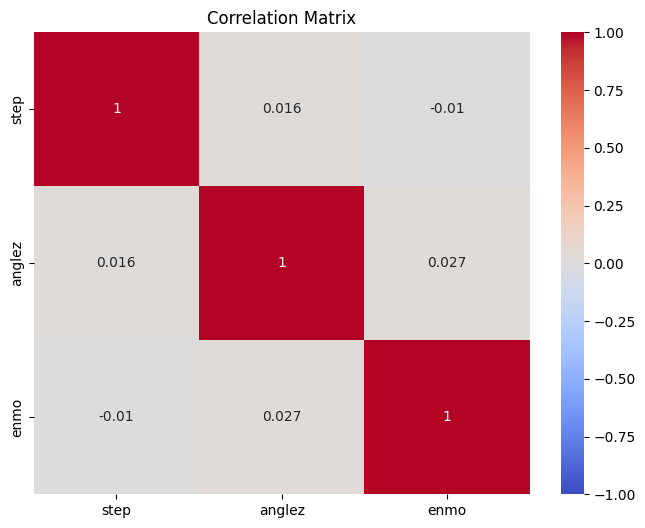

In [29]:
# Calculer la matrice de corrélation
corr_matrix = train_series_filtered[['step', 'anglez', 'enmo']].corr()

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

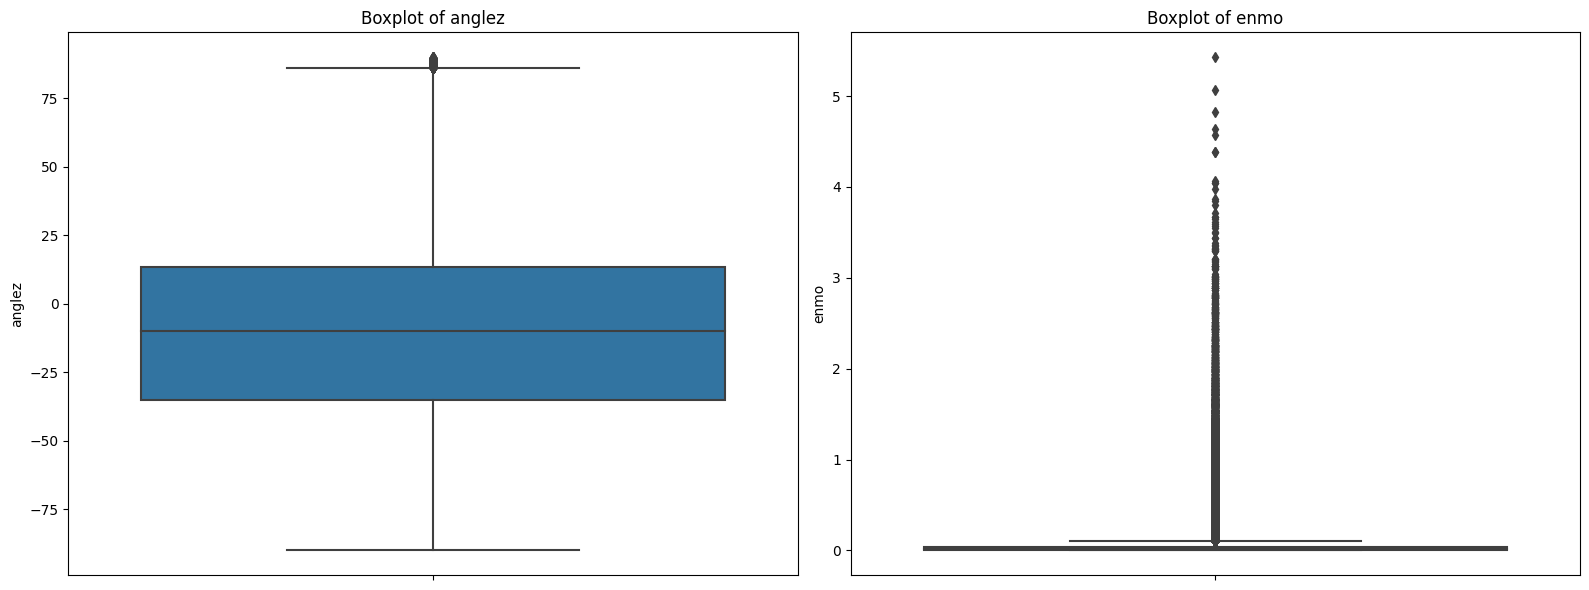

In [30]:
# Créer une figure avec deux sous-plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot pour 'anglez'
sns.boxplot(y=train_series_filtered['anglez'], ax=axes[0])
axes[0].set_title('Boxplot of anglez')

# Boxplot pour 'enmo'
sns.boxplot(y=train_series_filtered['enmo'], ax=axes[1])
axes[1].set_title('Boxplot of enmo')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

## Train events vizualization

---

In [32]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [33]:
print(f"Total amount of unique seriesIDs: {len(train_events['series_id'].unique())}\n")
train_events.describe()

Total amount of unique seriesIDs: 277



,night,step
count,14508.000000,9585.000000
mean,15.120072,214352.123944
std,10.286758,141268.408192
min,1.000000,936.000000
25%,7.000000,95436.000000
50%,14.000000,200604.000000
75%,21.000000,317520.000000
max,84.000000,739392.000000


We can see that ```train_events``` is composed of:
* 14508 rows for 277 individuals
* 5 columns : ```series_id```, ```night```, ```event```, ```step``` and ```timestamp```.  

In [34]:
nan_counts = train_events.isnull().sum()
print(f"Number of missing values by columns:\n{nan_counts}")

Number of missing values by columns:
series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


There are **4923** missing values for ```step``` and ```timestamp```.

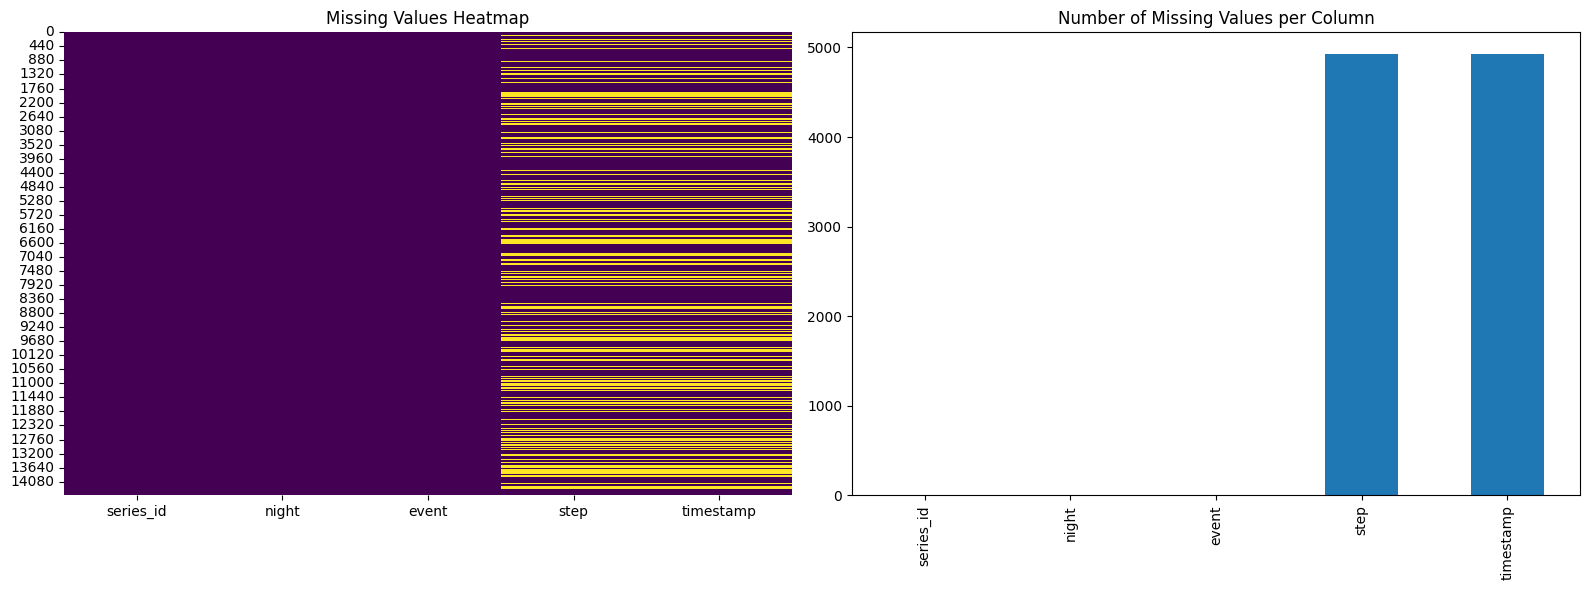

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Missing values visualization (Heatmap)
sns.heatmap(train_events.isna(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Number of Nan by columns (Barplot)
train_events.isna().sum().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Missing Values per Column')

# Show plots
plt.tight_layout()
plt.show()

Missing values are evenly distributed across the dataset. They are the same for ```step``` and ```timestamp```.

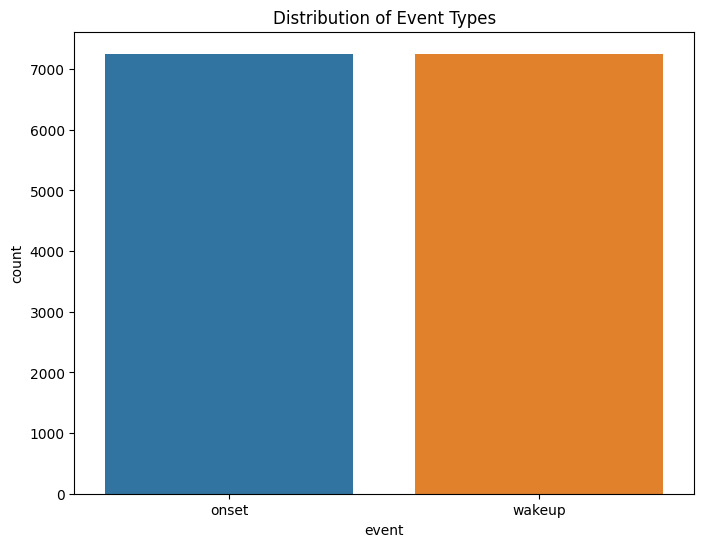

In [36]:
# Compter la fréquence des différents types d'événements
# Count the frequency of different event types
plt.figure(figsize=(8, 6))
sns.countplot(x='event', data=train_events)
plt.title('Distribution of Event Types')
plt.show()

The distribution of event types is the same for **onset** and **wakeup**

/tmp/ipykernel_30/2847054099.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


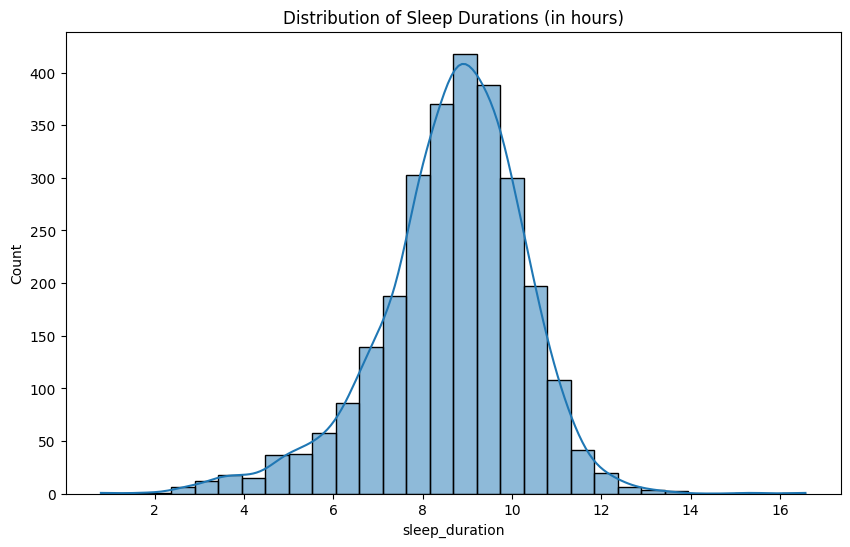

In [37]:
# Convert timestamps to datetime in the original DataFrame
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Create separate DataFrames for ‘onset’ and ‘wakeup’ events
onset_df = train_events[train_events['event'] == 'onset']
wakeup_df = train_events[train_events['event'] == 'wakeup']

# Merge onset and wakeup on ‘series_id’ and ‘night’ for each night
sleep_durations = pd.merge(onset_df, wakeup_df, on=['series_id', 'night'], suffixes=('_onset', '_wakeup'))

# Ensure that timestamp columns are of type datetime
sleep_durations['timestamp_onset'] = pd.to_datetime(sleep_durations['timestamp_onset'], errors='coerce')
sleep_durations['timestamp_wakeup'] = pd.to_datetime(sleep_durations['timestamp_wakeup'], errors='coerce')

# Calculate the length of each night in hours
sleep_durations['sleep_duration'] = (sleep_durations['timestamp_wakeup'] - sleep_durations['timestamp_onset']).dt.total_seconds() / 3600

# Visualisation of sleep times
plt.figure(figsize=(10, 6))
sns.histplot(sleep_durations['sleep_duration'], bins=30, kde=True)
plt.title('Distribution of Sleep Durations (in hours)')
plt.show()

Sleep duration appears to follow a normal distribution centred around **9 hours** of sleep.

/tmp/ipykernel_30/3547846503.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_events['hour'] = train_events['timestamp'].dt.hour
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


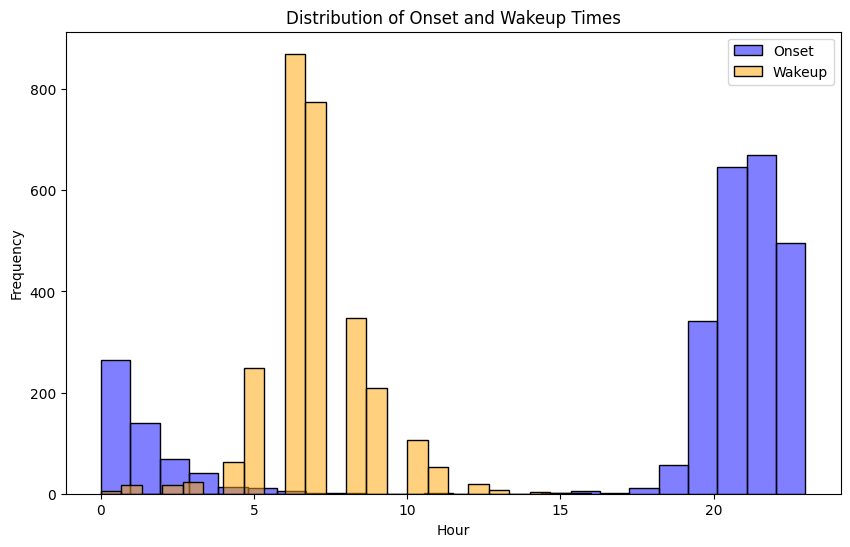

In [38]:
# Convert timestamps into datetime, replacing non-convertible values with NaT
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Delete rows with NaT in the ‘timestamp’ column
train_events = train_events.dropna(subset=['timestamp'])

# Extract time from timestamps for onset and wakeup events
train_events['hour'] = train_events['timestamp'].dt.hour

# Viewing onset and wakeup times without KDE
plt.figure(figsize=(10, 6))
sns.histplot(train_events[train_events['event'] == 'onset']['hour'], color='blue', label='Onset', kde=False, bins=24, alpha = 0.5)
sns.histplot(train_events[train_events['event'] == 'wakeup']['hour'], color='orange', label='Wakeup', kde=False, bins=24, alpha = 0.5)
plt.title('Distribution of Onset and Wakeup Times')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that the majority of people wake up between 5am and 10am and fall asleep between 8pm and 1am.

## Test series vizualization

---

In [39]:
test_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18T12:57:05-0500,-59.696899,0.0601
446,0402a003dae9,146,2018-12-18T12:57:10-0500,-35.656601,0.0427
447,0402a003dae9,147,2018-12-18T12:57:15-0500,-21.582399,0.0309
448,0402a003dae9,148,2018-12-18T12:57:20-0500,-42.616001,0.0328


In [40]:
test_series.describe()

,step,anglez,enmo
count,450.0000,450.000000,450.000000
mean,74.5000,-56.177723,0.030276
std,43.3485,39.331936,0.067950
min,0.0000,-88.367996,0.000000
25%,37.0000,-88.216599,0.000000
50%,74.5000,-79.989449,0.013300
75%,112.0000,-29.100624,0.035250
max,149.0000,68.460503,0.980200


In [41]:
print(f"Total amount of unique seriesIDs: {len(test_series['series_id'].unique())}\n")
print(f"Total amount of unique seriesIDs: {len(test_series['series_id'].unique())}\n")

nan_counts_test = test_series.isnull().sum() 
print(f"Amount of missing values per column:\n{nan_counts_test}")
nan_counts_test = test_series.isnull().sum() 
print(f"Amount of missing values per column:\n{nan_counts_test}")

Total amount of unique seriesIDs: 3

Total amount of unique seriesIDs: 3

Amount of missing values per column:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64
Amount of missing values per column:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64


We can see that `test_series` is composed of :
- 450 rows for 3 individuals
- 5 columns : series_id, step, timestamp, anglez and enmo


There are no missing values in this dataset.

In order to better visualize the data in the `test_series` dataset, we'll plot both `anglez` and `enmo` against `step` for each `series_id`.

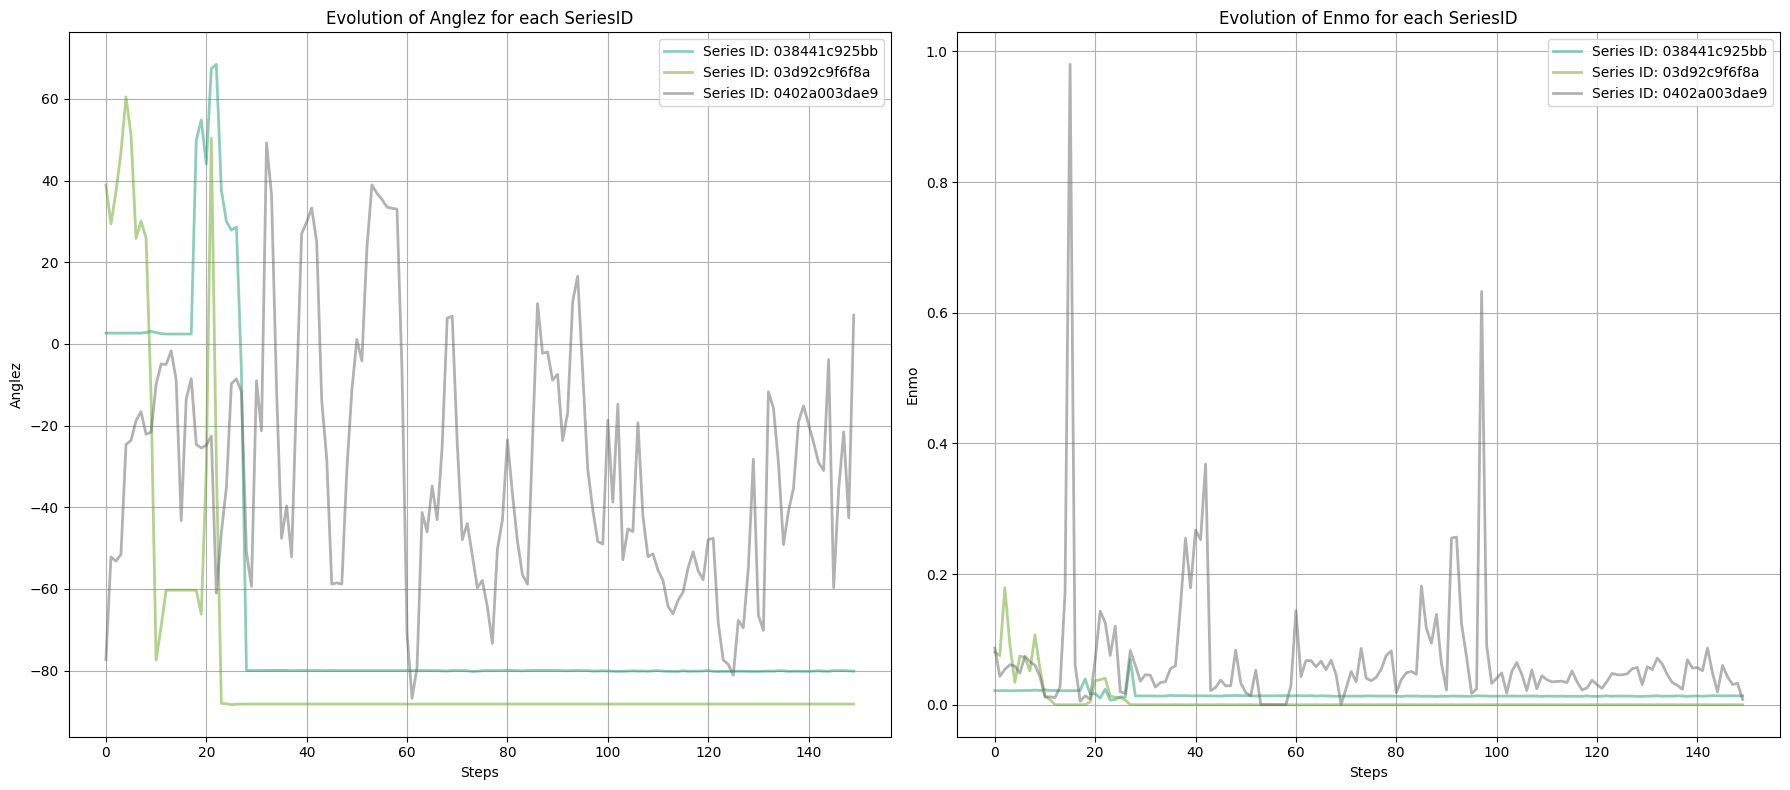

In [42]:
# Create a color map for unique series IDs
test_ids = test_series['series_id'].unique()
colors = plt.cm.Dark2(np.linspace(0, 1, len(test_ids)))  # Generate colors for each unique series ID

# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns

# Plot Evolution of Anglez for each Series ID on the first subplot
for color, series_id in zip(colors, test_ids):
    series_data = test_series[test_series['series_id'] == series_id]  # Filter data for each series_id
    axes[0].plot(series_data['step'], series_data['anglez'],
                 label=f'Series ID: {series_id}', color=color, alpha=0.5, linewidth=2)  # Plot anglez data

# Customize the first subplot
axes[0].set_title('Evolution of Anglez for each SeriesID')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Anglez')
axes[0].legend()
axes[0].grid(True)

# Plot Evolution of Enmo for each Series ID on the second subplot
for color, series_id in zip(colors, test_ids):
    series_data = test_series[test_series['series_id'] == series_id]  # Filter data for each series_id
    axes[1].plot(series_data['step'], series_data['enmo'],
                 label=f'Series ID: {series_id}', color=color, alpha=0.5, linewidth=2)  # Plot enmo data

# Customize the second subplot
axes[1].set_title('Evolution of Enmo for each SeriesID')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Enmo')
axes[1].legend()
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

The plots clearly depict movement and orientation patterns captured by the accelerometer for three individuals, highlighting differences in their recorded activities.

The main observation we can make is regarding the uniform duration of recorded steps for each individual: all three series contain **150 steps**, equivalent to **12.5 minutes** (1 step = 5 seconds). This limited data suggests that the provided `test_series` dataset is incomplete. Through discussions on this issue, it’s understood that the complete `test_series` dataset is kept private and will replace the partial version once we submit our model for scoring. Thus, the limited data and shorter graphs in the public `test_series` dataset are expected.